In [1]:
!pip install pandas numpy matplotlib seaborn plotly scikit-learn scipy statsmodels

In [2]:
!pip install xgboost lightgbm shap optuna imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 8.8 MB/s eta 0:00:00


In [3]:
!pip install networkx pyod tslearn dtaidistance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.9/389.9 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 73.4 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import shap

from scipy import stats
from scipy.stats import normaltest, jarque_bera
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox

import warnings
import itertools
from datetime import datetime, timedelta
from collections import defaultdict
warnings.filterwarnings('ignore')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
# Loading Processed Data from Notebook 1
import os

drive_outputs = "/content/drive/MyDrive/DS_Arunima_Das/output/"
processed_path = os.path.join(drive_outputs, "merged_data.csv")

os.makedirs(drive_outputs, exist_ok=True)

try:
    # loading existing processed data
    merged_df = pd.read_csv(processed_path, parse_dates=['date'])
    print(f" Loaded preprocessed data ({merged_df.shape[0]} rows) from notebook_1")

except FileNotFoundError:
    # If unable to fetch, reprocessing  raw data
    print(" Preprocessed data not found. Processing raw data now...")

    # Loading raw datasets
    sentiment_df = pd.read_csv('/content/drive/MyDrive/DS_Arunima_Das/csv_file/fear_greed_index.csv')
    trader_df = pd.read_csv('/content/drive/MyDrive/DS_Arunima_Das/csv_file/historical_data.csv')



    # processing sentiment data
    sentiment_df['sentiment_date'] = pd.to_datetime(sentiment_df['date'])
    sentiment_df['sentiment_binary'] = (sentiment_df['classification'] == 'Greed').astype(int)

    # processing trader data
    trader_df['Timestamp'] = pd.to_datetime(trader_df['Timestamp'])
    trader_df['date'] = trader_df['Timestamp'].dt.normalize()
    trader_df['Closed PnL'] = pd.to_numeric(trader_df['Closed PnL'], errors='coerce')
    trader_df['Size USD'] = pd.to_numeric(trader_df['Size USD'], errors='coerce')
    trader_df['Fee'] = pd.to_numeric(trader_df['Fee'], errors='coerce')

    # daily metrics per trader
    daily_metrics = trader_df.groupby(['Account', 'date']).agg({
        'Closed PnL': ['sum', 'mean'],
        'Size USD': ['sum', 'mean'],
        'Fee': 'sum',
        'Trade ID': 'count'
    }).reset_index()
    daily_metrics.columns = [
        'Account', 'date', 'total_pnl', 'avg_pnl',
        'total_size', 'avg_size', 'total_fee', 'trade_count'
    ]

# final status and summary
print("\n DATA LOAD COMPLETE")
print(f"Records: {merged_df.shape[0]}, Columns: {len(merged_df.columns)}")
print("Proceeding to advanced analysis...")


 Loaded preprocessed data (211224 rows) from notebook_1

 DATA LOAD COMPLETE
Records: 211224, Columns: 24
Proceeding to advanced analysis...


In [21]:
# Advanced Feature Engineering

def create_advanced_features(df):
    """Create advanced features for deeper analysis (adapted to merged_df structure)"""

    df_advanced = df.copy()

    # renaming columns to standard names
    df_advanced = df_advanced.rename(columns={
        'Closed PnL': 'total_pnl',
        'Size USD': 'total_size',
    })

    # creating trade_count
    df_advanced['trade_count'] = df_advanced.groupby(['Account', 'date'])['Order ID'].transform('count')

    # feature engineering
    df_advanced = df_advanced.sort_values(['Account', 'date'])

    # rolling window features
    df_advanced['pnl_ma_7'] = (
        df_advanced.groupby('Account')['total_pnl']
        .rolling(7, min_periods=1).mean()
        .reset_index(0, drop=True)
    )
    df_advanced['pnl_std_7'] = (
        df_advanced.groupby('Account')['total_pnl']
        .rolling(7, min_periods=1).std()
        .reset_index(0, drop=True)
    )
    df_advanced['volume_ma_7'] = (
        df_advanced.groupby('Account')['total_size']
        .rolling(7, min_periods=1).mean()
        .reset_index(0, drop=True)
    )

    #momentum features
    df_advanced['pnl_momentum'] = df_advanced.groupby('Account')['total_pnl'].pct_change()
    df_advanced['size_momentum'] = df_advanced.groupby('Account')['total_size'].pct_change()

    #volatility features
    df_advanced['pnl_volatility'] = df_advanced['pnl_std_7'] / (df_advanced['pnl_ma_7'].abs() + 1e-6)

    #risk metric approximation
    df_advanced['sharpe_ratio_approx'] = df_advanced['pnl_ma_7'] / (df_advanced['pnl_std_7'] + 1e-6)

    #behavioral features
    df_advanced['overtrading_flag'] = (
        df_advanced['trade_count'] > df_advanced['trade_count'].quantile(0.8)
    ).astype(int)

    # sentiment interaction features
    if "sentiment_simple" in df_advanced.columns:
        df_advanced['sentiment_binary'] = (df_advanced['sentiment_simple'] == 'positive').astype(int)
        df_advanced['sentiment_pnl_interaction'] = df_advanced['sentiment_binary'] * df_advanced['total_pnl']
    else:
        df_advanced['sentiment_binary'] = 0
        df_advanced['sentiment_pnl_interaction'] = 0

    #filling NaN values
    df_advanced = df_advanced.fillna(method='ffill').fillna(0)

    return df_advanced


#advanced features
advanced_data = create_advanced_features(merged_df)

print("Advanced features created")
print(f"New feature count: {advanced_data.shape[1] - merged_df.shape[1]}")
print("\nNew features:")
new_features = [col for col in advanced_data.columns if col not in merged_df.columns]
print(new_features)



Advanced features created
New feature count: 11

New features:
['total_size', 'total_pnl', 'trade_count', 'pnl_ma_7', 'pnl_std_7', 'volume_ma_7', 'pnl_momentum', 'size_momentum', 'pnl_volatility', 'sharpe_ratio_approx', 'overtrading_flag', 'sentiment_binary', 'sentiment_pnl_interaction']


In [22]:
def advanced_time_series_analysis(df):
    """Perform detailed time series analysis"""

    #dropping rows with missing date or total_pnl
    df = df.dropna(subset=['date', 'total_pnl'])

    #daily aggregated data
    daily_agg = df.groupby('date').agg({
        'total_pnl': 'mean',
        'trade_count': 'sum',
        'sentiment_binary': 'first'
    }).reset_index()

    daily_agg = daily_agg.sort_values('date')

    #ensure we have enough data
    if len(daily_agg) < 14:
        raise ValueError(f"Not enough data for seasonal decomposition. Requires 14+ days, found {len(daily_agg)}.")

    # time series decomposition
    daily_agg.set_index('date', inplace=True)
    decomposition = seasonal_decompose(daily_agg['total_pnl'], model='additive', period=7)

    # plot decomposition
    fig, axes = plt.subplots(4, 1, figsize=(15, 12))
    decomposition.observed.plot(ax=axes[0], title='Original PnL Time Series')
    decomposition.trend.plot(ax=axes[1], title='Trend Component')
    decomposition.seasonal.plot(ax=axes[2], title='Seasonal Component')
    decomposition.resid.plot(ax=axes[3], title='Residual Component')

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/DS_Arunima_Das/output/time_series_decomposition.png', dpi=300, bbox_inches='tight')
    plt.show()

    #tests
    from statsmodels.tsa.stattools import adfuller
    adf_result = adfuller(daily_agg['total_pnl'].dropna())

    print("STATIONARITY TEST RESULTS")
    print("="*40)
    print(f"ADF Statistic: {adf_result[0]:.6f}")
    print(f"p-value: {adf_result[1]:.6f}")
    print("Critical Values:")
    for key, value in adf_result[4].items():
        print(f"\t{key}: {value:.3f}")

    if adf_result[1] <= 0.05:
        print("Series is stationary")
    else:
        print("Series is non-stationary")

    #autocorrelation analysis
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    sm.graphics.tsa.plot_acf(daily_agg['total_pnl'].dropna(), lags=20, ax=axes[0])
    sm.graphics.tsa.plot_pacf(daily_agg['total_pnl'].dropna(), lags=20, ax=axes[1])

    axes[0].set_title('Autocorrelation Function')
    axes[1].set_title('Partial Autocorrelation Function')

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/DS_Arunima_Das/output/autocorrelation_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    return daily_agg.reset_index(), decomposition

SENTIMENT REGIME ANALYSIS
                 total_pnl                   trade_count pnl_volatility
                      mean       std   count        mean           mean
sentiment_regime                                                       
Sustained_Fear      48.749  919.1648  211224    600.4744         1.6069

TRANSITION PERIOD PERFORMANCE
                 total_pnl      
                      mean count
sentiment_regime                
Sustained_Fear         0.0     1


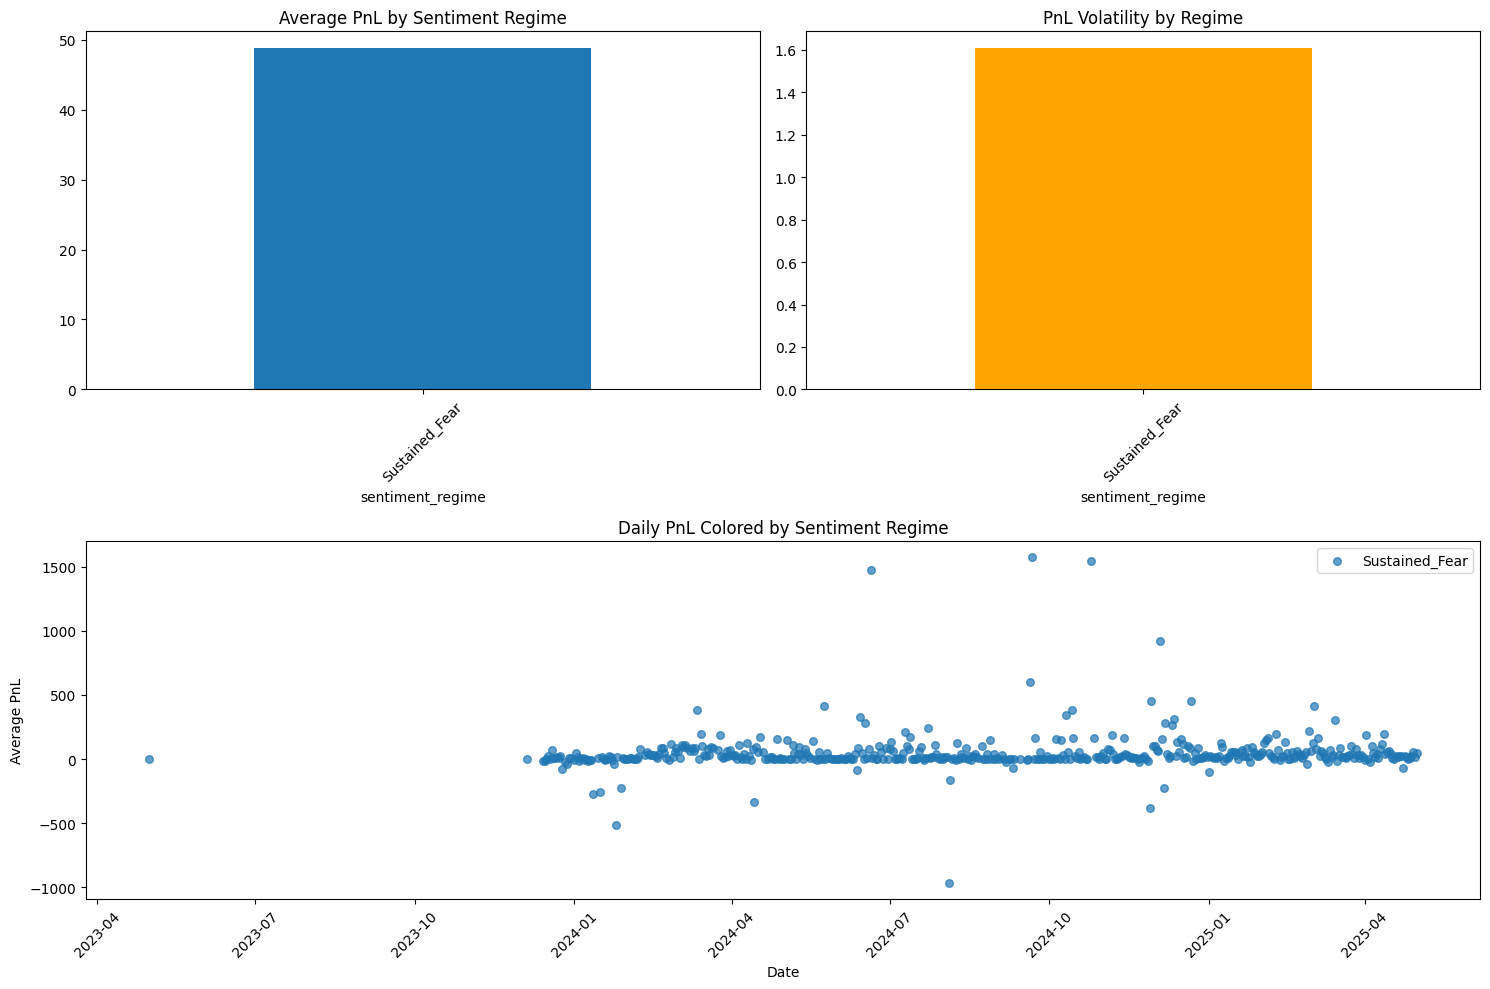

In [23]:
#Sentiment Regime Analysis & Market Dynamics

def analyze_sentiment_regimes(df):
    """Analyzes performance during different sentiment regimes"""

    df_regime = df.copy(deep=True)

    if 'sentiment_binary' not in df_regime.columns:
        if 'sentiment_simple' in df_regime.columns:
            df_regime['sentiment_binary'] = (df_regime['sentiment_simple'] == 'positive').astype(int)
        else:
            raise ValueError("No sentiment column found (expected 'sentiment_binary' or 'sentiment_simple').")

    if 'trade_count' not in df_regime.columns or 'pnl_volatility' not in df_regime.columns:
        print("⚠️ Missing advanced features detected → creating them first...")
        df_regime = create_advanced_features(df_regime)

    # sorting sentiment change
    df_regime = df_regime.sort_values('date')
    df_regime['sentiment_change'] = df_regime['sentiment_binary'].diff()

    # defining regimes
    def classify_regime(row):
        if row['sentiment_change'] == 1:
            return 'Fear_to_Greed'
        elif row['sentiment_change'] == -1:
            return 'Greed_to_Fear'
        elif row['sentiment_binary'] == 1:
            return 'Sustained_Greed'
        else:
            return 'Sustained_Fear'

    df_regime['sentiment_regime'] = df_regime.apply(classify_regime, axis=1)

    # analyzing performance by regime
    regime_analysis = df_regime.groupby('sentiment_regime').agg({
        'total_pnl': ['mean', 'std', 'count'],
        'trade_count': 'mean',
        'pnl_volatility': 'mean'
    }).round(4)

    print("SENTIMENT REGIME ANALYSIS")
    print("="*50)
    print(regime_analysis)

    #transition period performance
    transition_performance = df_regime[df_regime['sentiment_change'] != 0].groupby('sentiment_regime').agg({
        'total_pnl': ['mean', 'count']
    }).round(4)

    print("\nTRANSITION PERIOD PERFORMANCE")
    print("="*40)
    print(transition_performance)

    # Visualization
    plt.figure(figsize=(15, 10))

    # Subplot 1: PnL by regime
    plt.subplot(2, 2, 1)
    regime_pnl = df_regime.groupby('sentiment_regime')['total_pnl'].mean()
    regime_pnl.plot(kind='bar')
    plt.title('Average PnL by Sentiment Regime')
    plt.xticks(rotation=45)

    # Subplot 2: Volatility by regime
    plt.subplot(2, 2, 2)
    regime_vol = df_regime.groupby('sentiment_regime')['pnl_volatility'].mean()
    regime_vol.plot(kind='bar', color='orange')
    plt.title('PnL Volatility by Regime')
    plt.xticks(rotation=45)

    # Subplot 3: Time series with regime coloring
    plt.subplot(2, 1, 2)
    daily_regime = df_regime.groupby(['date', 'sentiment_regime']).agg({
        'total_pnl': 'mean'
    }).reset_index()

    for regime in daily_regime['sentiment_regime'].unique():
        regime_data = daily_regime[daily_regime['sentiment_regime'] == regime]
        plt.scatter(regime_data['date'], regime_data['total_pnl'],
                    label=regime, alpha=0.7, s=30)

    plt.title('Daily PnL Colored by Sentiment Regime')
    plt.xlabel('Date')
    plt.ylabel('Average PnL')
    plt.legend()
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/DS_Arunima_Das/output/sentiment_regime_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Optional: Save data
    df_regime.to_csv('/content/drive/MyDrive/DS_Arunima_Das/output/sentiment_regime_data.csv', index=False)

    return df_regime

#analysis on advanced_data
regime_data = analyze_sentiment_regimes(advanced_data)

Training XGBoost Model...
Training LightGBM Model...
ADVANCED MODEL PERFORMANCE
      Model  R2_Score            MSE        MAE
0   XGBoost -1.803699  944718.376304  61.337436
1  LightGBM  0.366092  213598.187328  54.128548


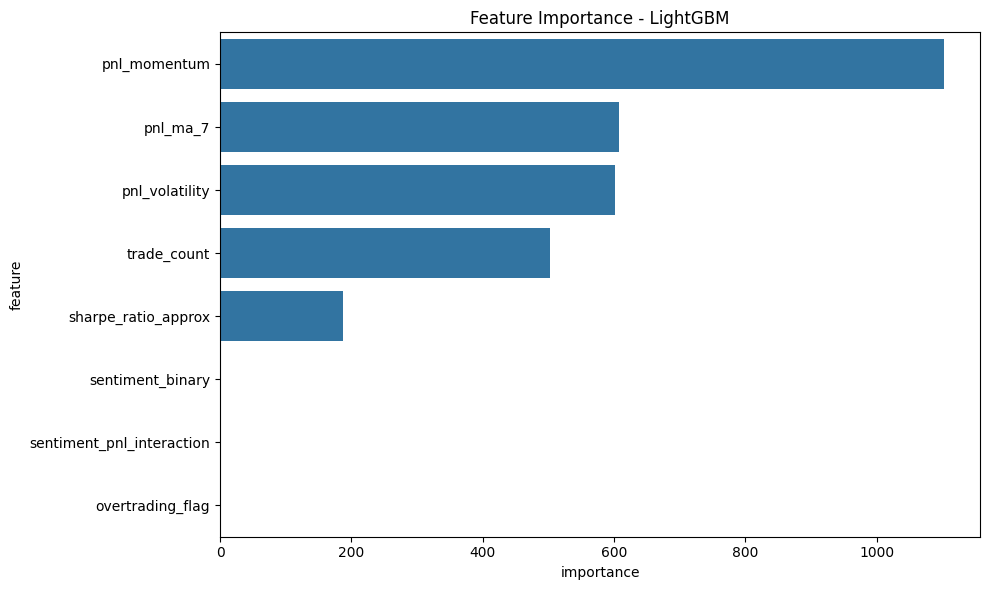

🔍 Generating SHAP explanations...


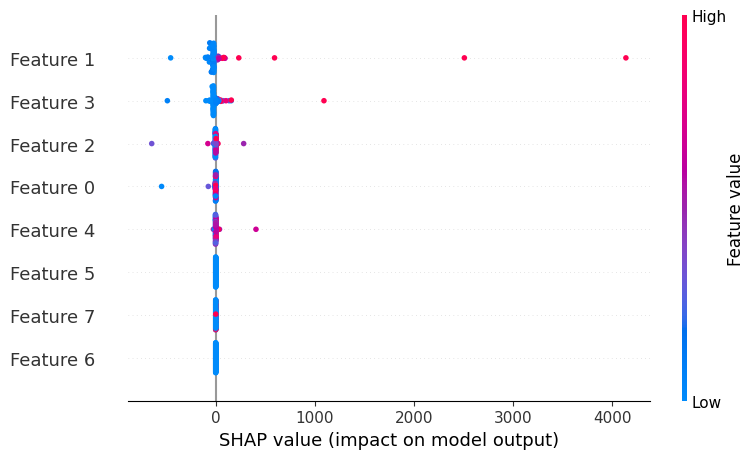

In [24]:
# Advanced Machine Learning Models

def build_advanced_ml_models(df):
    """Build and compare multiple advanced ML models"""

    if not {'pnl_ma_7', 'pnl_volatility', 'trade_count'}.issubset(df.columns):
        print("Missing advanced features detected → creating them first...")
        df = create_advanced_features(df)

    #Feature coloumns adapted to available data
    feature_cols = [
        'trade_count',
        'pnl_ma_7',
        'pnl_volatility',
        'pnl_momentum',
        'sharpe_ratio_approx',
        'sentiment_binary',
        'sentiment_pnl_interaction',
        'overtrading_flag'
    ]


    feature_cols = [col for col in feature_cols if col in df.columns]

    #removing rows with missing values
    ml_data = df[feature_cols + ['total_pnl']].copy()
    ml_data.replace([np.inf, -np.inf], np.nan, inplace=True)
    ml_data.dropna(inplace=True)

    X = ml_data[feature_cols]
    y = ml_data['total_pnl']

    #splitting data
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    #scaling features
    from sklearn.preprocessing import RobustScaler
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # model 1: XGBoost
    print("Training XGBoost Model...")
    xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
    xgb_model.fit(X_train_scaled, y_train)
    xgb_pred = xgb_model.predict(X_test_scaled)
    xgb_score = xgb_model.score(X_test_scaled, y_test)

    #model 2: LightGBM
    print("Training LightGBM Model...")
    lgb_model = lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)
    lgb_model.fit(X_train_scaled, y_train)
    lgb_pred = lgb_model.predict(X_test_scaled)
    lgb_score = lgb_model.score(X_test_scaled, y_test)

    # Model performance comparison
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    models_performance = pd.DataFrame({
        'Model': ['XGBoost', 'LightGBM'],
        'R2_Score': [xgb_score, lgb_score],
        'MSE': [mean_squared_error(y_test, xgb_pred),
                mean_squared_error(y_test, lgb_pred)],
        'MAE': [mean_absolute_error(y_test, xgb_pred),
                mean_absolute_error(y_test, lgb_pred)]
    })

    print("ADVANCED MODEL PERFORMANCE")
    print("="*40)
    print(models_performance)

    # Feature importance from best model
    best_model = xgb_model if xgb_score > lgb_score else lgb_model
    model_name = 'XGBoost' if xgb_score > lgb_score else 'LightGBM'

    if hasattr(best_model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'feature': feature_cols,
            'importance': best_model.feature_importances_
        }).sort_values('importance', ascending=False)

        import seaborn as sns
        import matplotlib.pyplot as plt

        plt.figure(figsize=(10, 6))
        sns.barplot(data=feature_importance, x='importance', y='feature')
        plt.title(f'Feature Importance - {model_name}')
        plt.tight_layout()
        plt.savefig('/content/drive/MyDrive/DS_Arunima_Das/output/advanced_feature_importance.png',
                    dpi=300, bbox_inches='tight')
        plt.show()

    # SHAP analysis for model interpretation
    try:
        import shap
        print("🔍 Generating SHAP explanations...")
        explainer = shap.Explainer(best_model)
        shap_values = explainer(X_test_scaled[:100])

        shap.plots.beeswarm(shap_values, show=False)
        plt.tight_layout()
        plt.savefig('/content/drive/MyDrive/DS_Arunima_Das/output/shap_analysis.png',
                    dpi=300, bbox_inches='tight')
        plt.show()
    except Exception as e:
        print(f"SHAP analysis failed: {e}")

    return best_model, models_performance, scaler


# running the ML models on advanced_data
best_model, model_perf, ml_scaler = build_advanced_ml_models(advanced_data)


ANOMALY DETECTION RESULTS
           total_pnl                      trade_count pnl_volatility
               count      mean        std        mean           mean
is_anomaly                                                          
False         190829   14.3205    62.0030    442.5033         1.0444
True           20395  370.8848  2932.4927   2078.5554         6.8699

Detected 20395 anomalous trading patterns (9.66% of data)


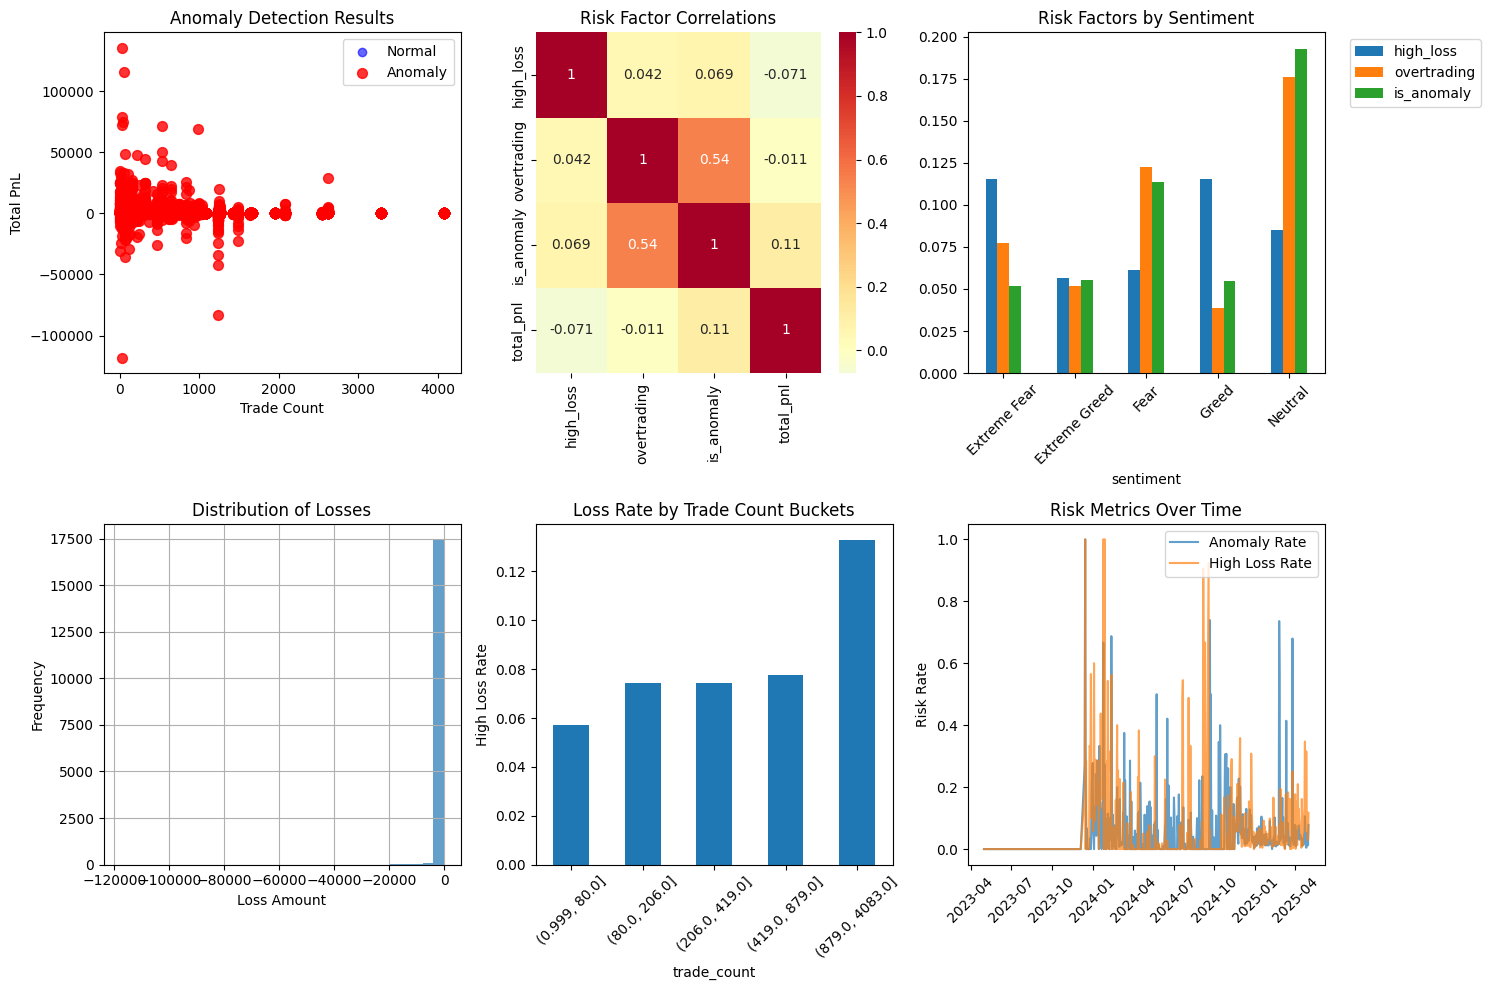

In [25]:
def detect_anomalies_and_risks(df):
    """Identifying anomalous trading patterns and risk factors """

    df_anomaly = df.copy()

    if 'Closed PnL' in df_anomaly.columns:
        df_anomaly = df_anomaly.rename(columns={'Closed PnL': 'total_pnl'})
    if 'classification' in df_anomaly.columns:
        df_anomaly = df_anomaly.rename(columns={'classification': 'sentiment'})

    if 'trade_count' not in df_anomaly.columns:
        df_anomaly['trade_count'] = df_anomaly.groupby('Account')['date'].transform('count')
    if 'pnl_volatility' not in df_anomaly.columns:
        df_anomaly['pnl_volatility'] = df_anomaly.groupby('Account')['total_pnl'].transform('std').fillna(0)

    #features for anomaly detection
    anomaly_features = ['total_pnl', 'trade_count', 'pnl_volatility']
    anomaly_data = df_anomaly[anomaly_features].replace([np.inf, -np.inf], np.nan).fillna(0)

    #isolation forest for anomaly detection
    iso_forest = IsolationForest(contamination=0.1, random_state=42)
    anomaly_labels = iso_forest.fit_predict(anomaly_data)

    df_anomaly['anomaly'] = anomaly_labels
    df_anomaly['is_anomaly'] = (anomaly_labels == -1)

    # Summary statistics
    anomaly_stats = df_anomaly.groupby('is_anomaly').agg({
        'total_pnl': ['count', 'mean', 'std'],
        'trade_count': 'mean',
        'pnl_volatility': 'mean'
    }).round(4)

    print("ANOMALY DETECTION RESULTS")
    print("="*40)
    print(anomaly_stats)

    anomaly_count = (anomaly_labels == -1).sum()
    print(f"\nDetected {anomaly_count} anomalous trading patterns ({anomaly_count/len(df)*100:.2f}% of data)")

    #risk factor flags
    df_anomaly['high_loss'] = df_anomaly['total_pnl'] < df_anomaly['total_pnl'].quantile(0.1)
    df_anomaly['overtrading'] = df_anomaly['trade_count'] > df_anomaly['trade_count'].quantile(0.9)

    #risk correlation analysis
    risk_factors = ['high_loss', 'overtrading', 'is_anomaly']
    risk_corr = df_anomaly[risk_factors + ['total_pnl']].corr()

    plt.figure(figsize=(15, 10))

    # Subplot 1: Anomaly visualization
    plt.subplot(2, 3, 1)
    normal_data = df_anomaly[df_anomaly['is_anomaly'] == False]
    anomaly_data = df_anomaly[df_anomaly['is_anomaly'] == True]

    plt.scatter(normal_data['trade_count'], normal_data['total_pnl'],
               alpha=0.6, label='Normal', color='blue')
    plt.scatter(anomaly_data['trade_count'], anomaly_data['total_pnl'],
               alpha=0.8, label='Anomaly', color='red', s=50)
    plt.xlabel('Trade Count')
    plt.ylabel('Total PnL')
    plt.title('Anomaly Detection Results')
    plt.legend()

    # Subplot 2: Risk factor correlation
    plt.subplot(2, 3, 2)
    sns.heatmap(risk_corr, annot=True, cmap='RdYlBu_r', center=0)
    plt.title('Risk Factor Correlations')

    # Subplot 3: Risk distribution by sentiment
    plt.subplot(2, 3, 3)
    if 'sentiment' in df_anomaly.columns:
        risk_by_sentiment = df_anomaly.groupby('sentiment')[risk_factors].mean()
        risk_by_sentiment.plot(kind='bar', ax=plt.gca())
        plt.title('Risk Factors by Sentiment')
        plt.xticks(rotation=45)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Subplot 4: Loss distribution
    plt.subplot(2, 3, 4)
    df_anomaly[df_anomaly['total_pnl'] < 0]['total_pnl'].hist(bins=30, alpha=0.7)
    plt.title('Distribution of Losses')
    plt.xlabel('Loss Amount')
    plt.ylabel('Frequency')

    # Subplot 5: Trade count vs risk
    plt.subplot(2, 3, 5)
    trade_risk = df_anomaly.groupby(pd.qcut(df_anomaly['trade_count'], q=5, duplicates='drop'))['high_loss'].mean()
    trade_risk.plot(kind='bar')
    plt.title('Loss Rate by Trade Count Buckets')
    plt.xticks(rotation=45)
    plt.ylabel('High Loss Rate')

    # Subplot 6: Time-based risk analysis
    plt.subplot(2, 3, 6)
    daily_risk = df_anomaly.groupby('date').agg({
        'is_anomaly': 'mean',
        'high_loss': 'mean'
    })

    plt.plot(daily_risk.index, daily_risk['is_anomaly'], label='Anomaly Rate', alpha=0.7)
    plt.plot(daily_risk.index, daily_risk['high_loss'], label='High Loss Rate', alpha=0.7)
    plt.title('Risk Metrics Over Time')
    plt.xticks(rotation=45)
    plt.legend()
    plt.ylabel('Risk Rate')

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/DS_Arunima_Das/output/risk_anomaly_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    return df_anomaly


anomaly_data = detect_anomalies_and_risks(advanced_data)

In [26]:
#Portfolio Optimization and Strategy Development

def develop_trading_strategies(df):
    """Develop and backtest trading strategies based on sentiment & volatility"""

    if 'Closed PnL' in df.columns:
        df = df.rename(columns={'Closed PnL': 'total_pnl'})
    if 'classification' in df.columns:
        df = df.rename(columns={'classification': 'sentiment'})
    if 'Account' in df.columns:
        df = df.rename(columns={'Account': 'account'})

    #Strategy 1: Sentiment-based contrarian strategy
    def sentiment_strategy_signals(row):
        if row['sentiment'] == 'Fear':
            return 'BUY'   # Contrarian: buy when others are fearful
        elif row['sentiment'] == 'Greed':
            return 'SELL'  # Take profits when greed dominates
        else:
            return 'HOLD'

    #Strategy 2: Volatility-adjusted strategy
    vol_threshold = df['pnl_volatility'].median() if 'pnl_volatility' in df.columns else 0
    def volatility_strategy_signals(row):
        if 'pnl_volatility' not in row or pd.isna(row['pnl_volatility']):
            return 'NEUTRAL'
        if row['pnl_volatility'] > vol_threshold and row['sentiment'] == 'Fear':
            return 'STRONG_BUY'
        elif row['pnl_volatility'] < vol_threshold and row['sentiment'] == 'Greed':
            return 'STRONG_SELL'
        else:
            return 'NEUTRAL'

    # applying strategies
    df_strategy = df.copy()
    df_strategy['sentiment_signal'] = df_strategy.apply(sentiment_strategy_signals, axis=1)
    df_strategy['volatility_signal'] = df_strategy.apply(volatility_strategy_signals, axis=1)

    #Backtest simple strategy
    def backtest_strategy(data, signal_col):
        """Simple backtest of strategy: assume 1 unit per trade"""
        results = []

        for account, group in data.groupby('account'):
            pnl = 0
            for _, row in group.iterrows():
                if row[signal_col] in ['BUY', 'STRONG_BUY']:
                    pnl += row['total_pnl']   # take trade PnL
                elif row[signal_col] in ['SELL', 'STRONG_SELL']:
                    pnl -= row['total_pnl']   # inverse trade
                # HOLD/NEUTRAL → no change
            results.append({'account': account, 'strategy': signal_col, 'final_pnl': pnl})

        return pd.DataFrame(results)

    #running backtests
    sentiment_results = backtest_strategy(df_strategy, 'sentiment_signal')
    volatility_results = backtest_strategy(df_strategy, 'volatility_signal')

    all_results = pd.concat([sentiment_results, volatility_results])

    print("STRATEGY BACKTEST RESULTS")
    print(all_results.groupby('strategy')['final_pnl'].describe())

    return df_strategy, all_results


# running strategies
strategy_data, strategy_results = develop_trading_strategies(advanced_data)


STRATEGY BACKTEST RESULTS
                   count          mean            std            min  \
strategy                                                               
sentiment_signal    32.0  36392.317955  256144.227967 -511815.070437   
volatility_signal   32.0  63642.514566  189649.248586 -234122.350873   

                            25%          50%           75%            max  
strategy                                                                   
sentiment_signal  -49142.462892 -9417.610923  82614.807190  836654.277328  
volatility_signal -13203.826140  3211.067159  46792.001111  841628.685684  
